**No notebook de [avaliacao_modelos.ipynb](avaliacao_modelos.ipynb), avaliei o desempenho dos modelos. Utilizando o recall como métrica de desempenho, constatei que o modelo de Redes Neurais Sequenciais obteve o melhor resultado nos dados de teste:**
- **Redes Neurais Sequenciais** obteve um recall de 73%.

- **Random Forest** teve desempenho de 60%.

- **CatBoost** obteve um recall de 66%.

**Com base nos custos monetários de manutenção para cada possível resultado (TP com valor de 25, TN com valor de 0, FP com valor de 10 e FN com valor de 500), avaliei o desempenho dos modelos através do custo monetário de manutenção dos sistemas de ar condicionado para diferentes thresholds. O modelo que apresentou o menor custo monetário foi:**
- **Random Forest** com um custo de 20.390 unidades monetárias para um threshold de 5%. 

- **Redes Neurais Sequenciais** teve um custo de 26.735 unidades monetárias para o mesmo threshold, 

- **CatBoost** teve um custo de 27.860 unidades monetárias.

**Ao analisar a matriz de confusão com um threshold de 5%, o modelo Random Forest conseguiu acertar 360 de 373, o modelo Redes Neurais acertou 345 de 373, e o modelo CatBoost acertou 338 de 373.**

# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,recall_score,roc_curve,confusion_matrix, precision_recall_curve, log_loss, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
from sklearn.base import BaseEstimator, RegressorMixin
import keras
import joblib
import pickle
from venn_abers import VennAbersCalibrator, VennAbers

2024-07-24 15:45:23.805450: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 15:45:23.872552: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 15:45:24.079126: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 15:45:25.650854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 15:46:08.349587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Importe os dados e modelos

In [2]:
dados_tratados = pickle.load(open('dados/dados_tratados.pickle', 'rb'))
x_treino = dados_tratados['x_treino']
y_treino = dados_tratados['y_treino']
x_teste = dados_tratados['x_teste']
y_teste = dados_tratados['y_teste']

print(x_treino.shape, y_treino.shape, x_teste.shape, y_teste.shape) 

(59606, 20) (59606,) (15891, 20) (15891,)


In [3]:
## Cat Boost
cat_boost_model = CatBoostClassifier()
cat_boost_model.load_model("modelos_salvos/cat_boost_model.cbm") 

## Random Forest
random_forest_model = joblib.load('modelos_salvos/random_forest_model.pkl')

## redes neurais
redes_neurais_model = keras.models.load_model('modelos_salvos/redes_neurais_model.h5')

In [4]:
modelos = {'Cat_Boost': cat_boost_model, 
           'Random_Forest': random_forest_model, 
           'Redes_Neurais': redes_neurais_model}

# Predicoes modelos

In [5]:
## predicao
y_pred_cat = cat_boost_model.predict(x_teste)
y_pred_random = random_forest_model.predict(x_teste)
y_pred_redes = (redes_neurais_model.predict(x_teste) > 0.5).astype(int).squeeze()

497/497 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


# Avaliando os modelos

## Classification Report

In [6]:
def report_metrics(modelos, x_teste, y_teste):
    for kay, model in modelos.items():
        print(kay)
        if kay == 'Redes_Neurais':
            y_proba = model.predict(x_teste)
            y_pred_redes_threshold = (y_proba > 0.5).astype(int).squeeze()
            print(classification_report(y_teste.values, y_pred_redes_threshold))
            print('-----------------------------------------------------------------')
        else:
            try:
                print(classification_report(y_teste.values, model.predict(x_teste)))
            except ValueError:
                print(classification_report(y_teste.values, model.predict(x_teste)[:, 1]))
            print('-----------------------------------------------------------------')

In [7]:
report_metrics(modelos, x_teste, y_teste)

Cat_Boost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15518
           1       0.90      0.66      0.76       373

    accuracy                           0.99     15891
   macro avg       0.94      0.83      0.88     15891
weighted avg       0.99      0.99      0.99     15891

-----------------------------------------------------------------
Random_Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15518
           1       0.91      0.60      0.72       373

    accuracy                           0.99     15891
   macro avg       0.95      0.80      0.86     15891
weighted avg       0.99      0.99      0.99     15891

-----------------------------------------------------------------
Redes_Neurais
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15518
           1       0.79   

## Matriz de Confusão

In [8]:
def matriz_confusao_plot(y_teste, y_pred):
    sns.heatmap(confusion_matrix(y_teste, y_pred),annot=True)
    plt.xlabel('Predicao',fontsize=18)
    plt.ylabel('Classes Reais',fontsize=18);
    plt.title('Matriz de confusao',fontsize=18)
    plt.show()

In [9]:
def matriz_confusao_plot(y_teste, y_pred, title="Matriz de Confusão"):
    cm = confusion_matrix(y_teste, y_pred)
    trace = go.Heatmap(
        z=cm,
        x=["Pred. Negativo", "Pred. Positivo"],
        y=["Verdadeiro Negativo", "Verdadeiro Positivo"],
        colorscale="Blues",
        showscale=True,
        text=cm,
        texttemplate="%{text}",
        textfont={"size":18}
    )

    layout = go.Layout(
        title=title,
        xaxis=dict(title='Predição', tickvals=[0, 1], ticktext=["Negativo", "Positivo"]),
        yaxis=dict(title='Classe Real', tickvals=[0, 1], ticktext=["Negativo", "Positivo"]),
        width=1000,
        height=700
    )

    fig = go.Figure(data=[trace], layout=layout)
    fig.show()
    
def matriz_confusao_plotly(modelos, x_teste, y_teste):
    for kay, model in modelos.items():
        if kay == 'Redes_Neurais':
            y_proba = model.predict(x_teste)
            y_pred_redes = (y_proba > 0.5).astype(int).squeeze()
            matriz_confusao_plot(y_teste, y_pred_redes, f'Matriz de Confusão {kay}')
        else:
            matriz_confusao_plot(y_teste, model.predict(x_teste), f'Matriz de Confusão {kay}')

In [10]:
modelos

{'Cat_Boost': <catboost.core.CatBoostClassifier at 0x7fab5ac7eff0>,
 'Random_Forest': RandomForestClassifier(max_depth=70, max_features=6, n_estimators=70),
 'Redes_Neurais': <Sequential name=sequential, built=True>}

In [11]:
def matriz_confusao_matplotlib(modelos,y_teste, x_teste, diretorio, salvar=False, threshold=0.5):
    for kay, model in modelos.items():
        if kay == 'Redes_Neurais':
            y_proba = model.predict(x_teste)
            y_pred_redes = (y_proba > threshold).astype(int).squeeze()
            plt.figure(figsize=(10,6))
            sns.heatmap(confusion_matrix(y_teste.values, y_pred_redes),annot=True,fmt='g')
            plt.xlabel('Predicao',fontsize=18)
            plt.ylabel('Classes Reais',fontsize=18);
            plt.title(f'Matriz de confusao {kay}',fontsize=18)
            if salvar:
                plt.savefig(f'imagens/{diretorio}_{kay}.png')
            plt.show()  
        else:
            plt.figure(figsize=(10,6))
            try:
                sns.heatmap(confusion_matrix(y_teste.values, (model.predict_proba(x_teste)[:,1]>threshold).astype(int)),annot=True,fmt='g')
            except ValueError:
                sns.heatmap(confusion_matrix(y_teste.values, model.predict(x_teste)[:, 1] > threshold),annot=True,fmt='g')
            plt.xlabel('Predicao',fontsize=18)
            plt.ylabel('Classes Reais',fontsize=18);
            plt.title(f'Matriz de confusao {kay}',fontsize=18)
            if salvar:
                plt.savefig(f'imagens/{diretorio}_{kay}.png')
            plt.show()

        print('-----------------------------------------------------------------')

In [12]:
matriz_confusao_plotly(modelos, x_teste, y_teste)

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


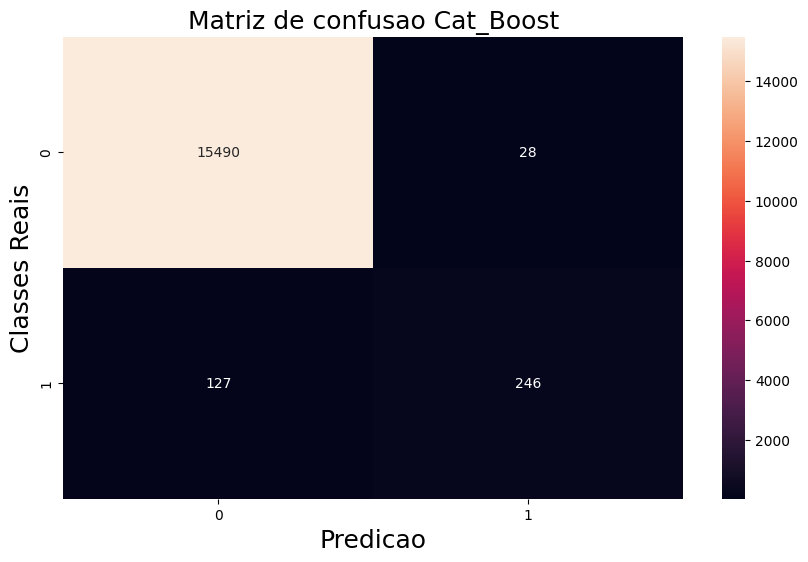

-----------------------------------------------------------------


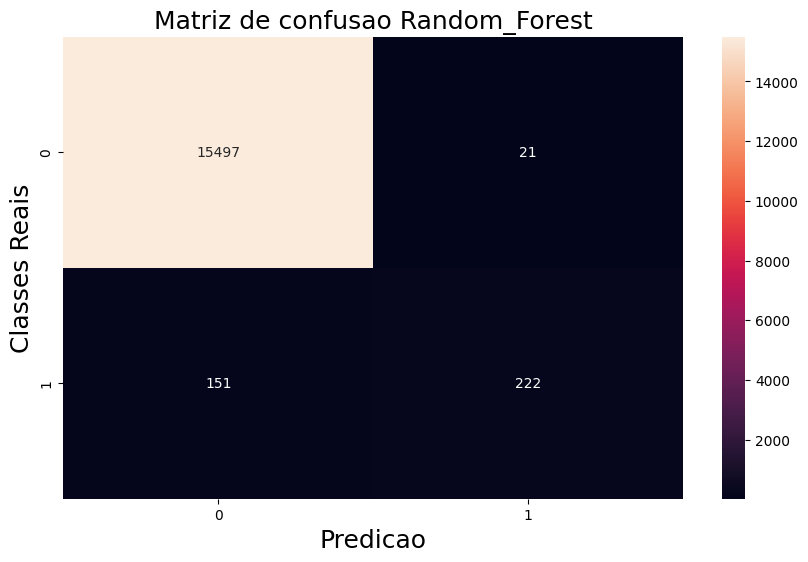

-----------------------------------------------------------------
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


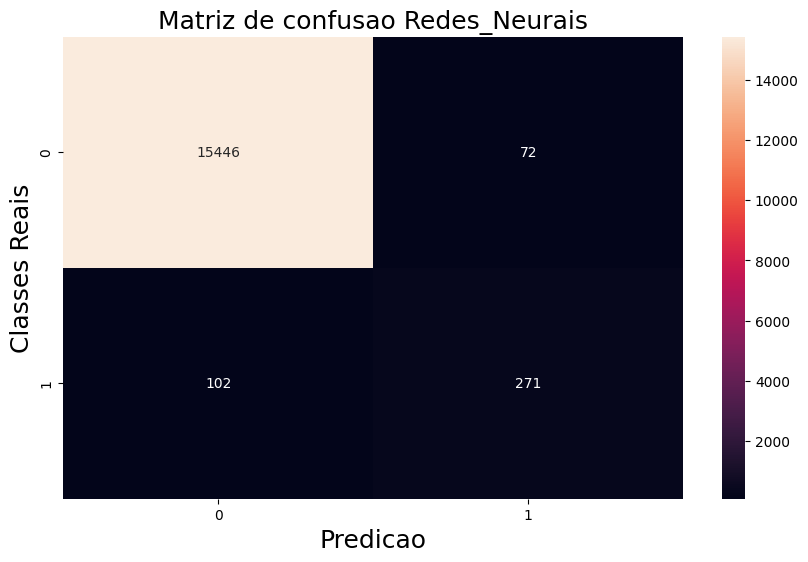

-----------------------------------------------------------------


In [13]:
matriz_confusao_matplotlib(modelos,y_teste, x_teste, diretorio='matriz_confusao', threshold=0.5, salvar=True)

## Curva ROC

In [14]:
def curva_roc(modelos):
    dict_recal = {}
    for kay, model in modelos.items():
        if kay == 'Redes_Neurais':
            y_proba = model.predict(x_treino)
            y_scores = (y_proba > 0.50).astype(int).squeeze()
            fpr, tpr, thresholds = roc_curve(y_treino,y_scores)
        else:
            y_scores = cross_val_predict(model, x_treino, y_treino, cv=3)
            fpr, tpr, thresholds = roc_curve(y_treino,y_scores)
        dict_recal[kay+'_fpr'], dict_recal[kay+'_tpr'], dict_recal[kay+'_thresholds'] = fpr, tpr, thresholds
    return dict_recal
dict_roc = curva_roc(modelos)

0:	learn: 0.4355482	total: 199ms	remaining: 59.4s
1:	learn: 0.2812907	total: 249ms	remaining: 37.1s
2:	learn: 0.1825309	total: 293ms	remaining: 29s
3:	learn: 0.1249119	total: 333ms	remaining: 24.6s
4:	learn: 0.0911743	total: 385ms	remaining: 22.7s
5:	learn: 0.0714350	total: 419ms	remaining: 20.6s
6:	learn: 0.0573012	total: 455ms	remaining: 19s
7:	learn: 0.0488056	total: 485ms	remaining: 17.7s
8:	learn: 0.0430510	total: 514ms	remaining: 16.6s
9:	learn: 0.0394834	total: 540ms	remaining: 15.6s
10:	learn: 0.0363098	total: 567ms	remaining: 14.9s
11:	learn: 0.0336579	total: 602ms	remaining: 14.4s
12:	learn: 0.0319670	total: 643ms	remaining: 14.2s
13:	learn: 0.0305321	total: 670ms	remaining: 13.7s
14:	learn: 0.0294010	total: 697ms	remaining: 13.2s
15:	learn: 0.0283575	total: 724ms	remaining: 12.8s
16:	learn: 0.0275606	total: 755ms	remaining: 12.6s
17:	learn: 0.0267239	total: 784ms	remaining: 12.3s
18:	learn: 0.0260581	total: 808ms	remaining: 12s
19:	learn: 0.0254285	total: 834ms	remaining: 11

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dict_roc['Cat_Boost_fpr'], y=dict_roc['Cat_Boost_tpr'], mode='lines', name='Cat_Boost'))   
fig.add_trace(go.Scatter(x=dict_roc['Redes_Neurais_fpr'], y=dict_roc['Redes_Neurais_tpr'], mode='lines', name='Redes_Neurais'))
fig.add_trace(go.Scatter(x=dict_roc['Random_Forest_fpr'], y=dict_roc['Random_Forest_tpr'], mode='lines', name='Random_Forest'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='k--'))
fig.update_layout(
        title="Curva ROC",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        legend_title="Legenda",
        height=700,
        width=1500,
        yaxis=dict(range=[0, 1]),
        xaxis=dict(range=[0, 1])
        )

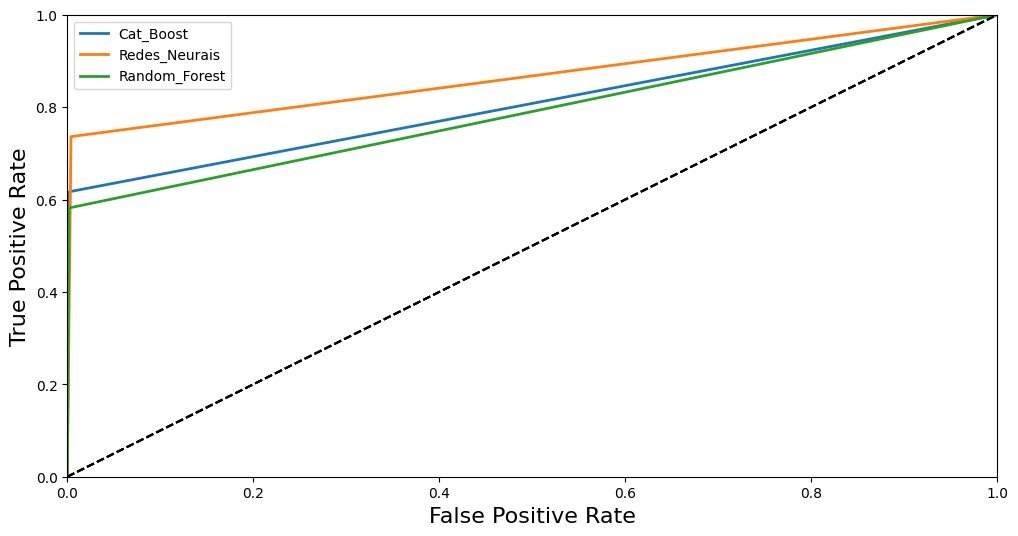

In [16]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(12, 6))
plot_roc_curve(dict_roc['Cat_Boost_fpr'], dict_roc['Cat_Boost_tpr'], 'Cat_Boost')
plot_roc_curve(dict_roc['Redes_Neurais_fpr'], dict_roc['Redes_Neurais_tpr'], 'Redes_Neurais')
plot_roc_curve(dict_roc['Random_Forest_fpr'], dict_roc['Random_Forest_tpr'], 'Random_Forest')
plt.legend()
plt.show()

## Curva de predicao de custo por threshold

Para avaliar os modelos baseados no custo associado a diferentes thresholds, você pode criar uma função de custo personalizada e plotar a curva de custo em função do threshold. Isso permitirá identificar o threshold que minimiza o custo total para cada modelo.

Definir os custos:

- Inspeção sem defeito: $10
- Inspeção com defeito: $25
- Correção sem inspeção: $500

In [17]:
def custo_monetario_threshold(modelos, x_teste, y_teste,):
    valor_monetario = {}
    lista_range = np.linspace(0, 1, 20)
    for kay, model in modelos.items():
        lista_valor_monetario = []
        for i in lista_range:
            if kay == 'Redes_Neurais':
                y_proba = model.predict(x_teste)
                y_pred_redes_threshold = (y_proba > i).astype(int)
                confusio = confusion_matrix(y_teste, y_pred_redes_threshold)
                lista_valor_monetario.append((confusio[0][0] * 0)+(confusio[1][1] * 25)+(confusio[0][1]*10)+(confusio[1][0]*500))
            else:
                y_proba = model.predict_proba(x_teste)[:,1]
                y_pred_redes_threshold = (y_proba > i).astype(int)
                confusio = confusion_matrix(y_teste, y_pred_redes_threshold)
                lista_valor_monetario.append((confusio[0][0] * 0)+(confusio[1][1] * 25)+(confusio[0][1]*10)+(confusio[1][0]*500))
        valor_monetario[kay] = lista_valor_monetario
    valor_monetario['range'] = lista_range

    predicao_custo = pd.DataFrame(index=valor_monetario['range'])
    for key in valor_monetario.keys():
        if key != 'range':
            predicao_custo[key] = valor_monetario[key]
    return predicao_custo
    


In [18]:
predicao_custo = custo_monetario_threshold(modelos, x_teste, y_teste)

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [19]:
predicao_custo.idxmin()[predicao_custo.min().idxmin()]

0.05263157894736842

In [20]:
def plot_custo_monetario_plotly(predicao_custo):
        fig = go.Figure()
        for key in predicao_custo.keys():
                if key != 'range':
                        fig.add_trace(go.Scatter(x=predicao_custo.index, y=predicao_custo[key], mode='lines', name=key))
        fig.add_vline(x=0.50, line=dict(color="black", width=2, dash="dash"), annotation_text="Threshold 50%", annotation_position="top right")
        fig.add_vline(x=predicao_custo.idxmin()[predicao_custo.min().idxmin()], line=dict(color="black", width=2, dash="dash"), annotation_text=f"Threshold de {round(predicao_custo.idxmin()[predicao_custo.min().idxmin()],2)*100}% com menor custo com valor de R${predicao_custo.min()[predicao_custo.min().idxmin()]} ", annotation_position="top right")
        fig.update_layout(
                title="Predição do Custo de manutenção por nivel de threshold",
                xaxis_title="Threshold",
                yaxis_title="Custo de Manutenção",
                legend_title="Legenda",
                height=700,
                width=1500,
                #yaxis=dict(range=[0, max(predicao_custo.index.to_list()) * 1.1]),
                ) 
        fig.show()
         

In [21]:
plot_custo_monetario_plotly(predicao_custo)

In [41]:
def plot_custo_monetario_matplotlib(predicao_custo, diretorio, salvar=False):
    plt.figure(figsize=(12, 6))
    for key in predicao_custo.keys():
        if key != 'range':
            plt.plot(predicao_custo.index, predicao_custo[key], linewidth=2, label=key)
    plt.axvline(x=0.50, color='red', linestyle='--', linewidth=2, label='Threshold 50%')
    plt.axvline(x=predicao_custo.idxmin()[predicao_custo.min().idxmin()], color='black', linestyle='--', linewidth=2, label=f"Threshold de {round(predicao_custo.idxmin()[predicao_custo.min().idxmin()],2)*100}% com menor custo com valor de R${predicao_custo.min()[predicao_custo.min().idxmin()]}")
    plt.xlabel("Threshold", fontsize=16)
    plt.ylabel("Custo de Manutenção", fontsize=16)
    plt.title("Predição do Custo de manutenção por nivel de threshold")
    plt.legend()
    if salvar:
        plt.savefig(f'imagens/{diretorio}.png')
    plt.show()

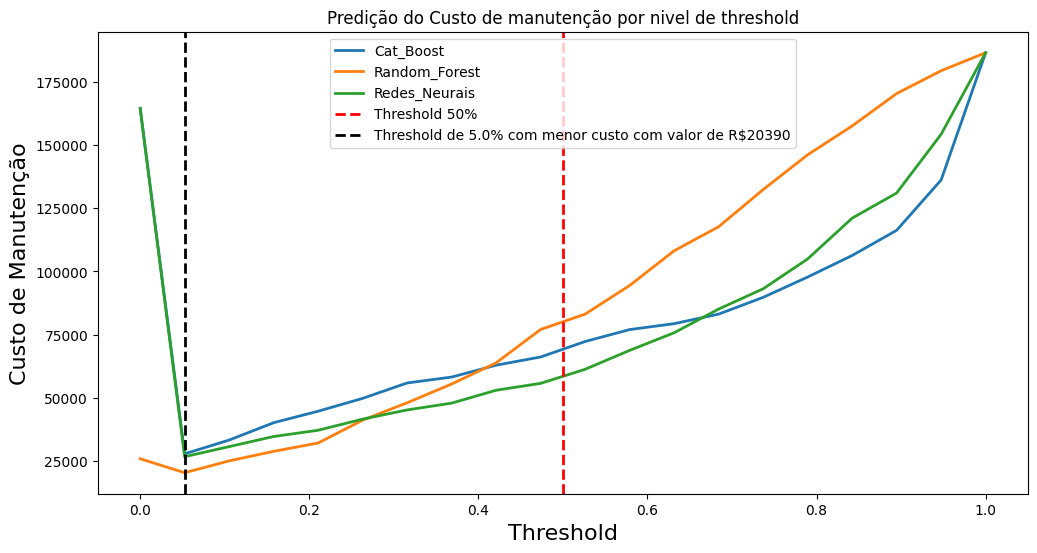

In [42]:
plot_custo_monetario_matplotlib(predicao_custo, 'custo_threshold', salvar=True)

In [24]:
predicao_custo

Cat_Boost  Random_Forest  Redes_Neurais
0.000000     164505          25915         164505
0.052632      27860          20390          26735
0.105263      33315          25070          30720
0.157895      40170          28850          34710
0.210526      44720          32140          37190
0.263158      49795          41190          41590
0.315789      55890          48055          45230
0.368421      58225          55475          47910
0.421053      62915          63845          53015
0.473684      66170          77055          55735
0.526316      72285          83130          61295
0.578947      77005          94440          68775
0.631579      79340         108175          75750
0.684211      83120         117675          85120
0.736842      89750         132380          93125
0.789474      97785         146135         104940
0.842105     106305         157535         121070
0.894737     116260         170350         131015
0.947368     136170         179375         154240
1.000000     186500         186500         186500

## Matriz de Confusão com o menor Threshold 

In [25]:
menor_custo = predicao_custo.idxmin()[predicao_custo.min().idxmin()]

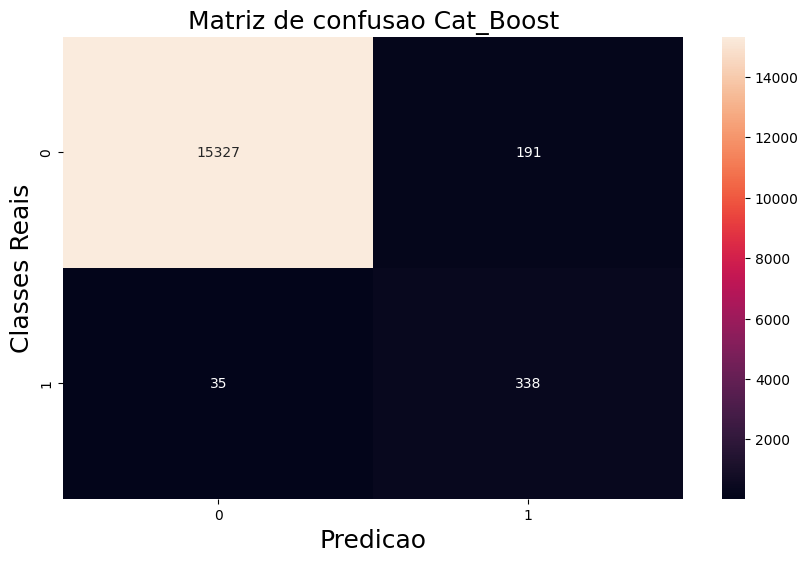

-----------------------------------------------------------------


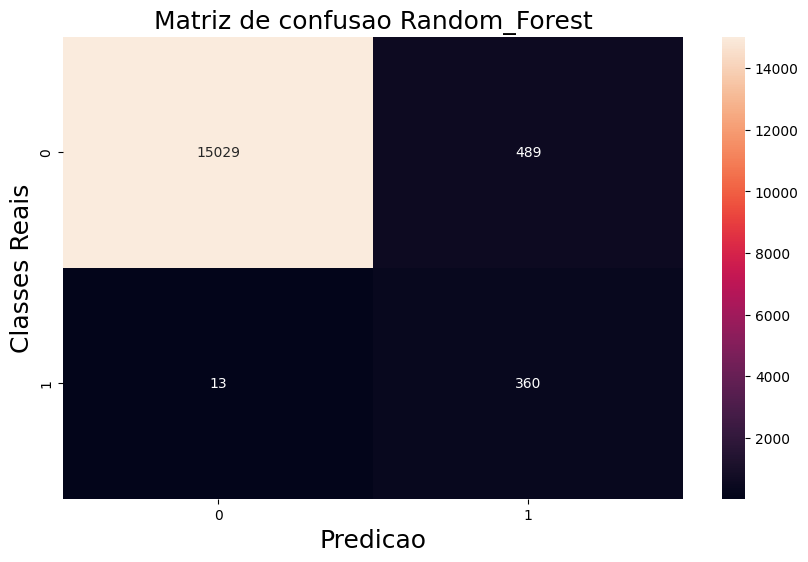

-----------------------------------------------------------------
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


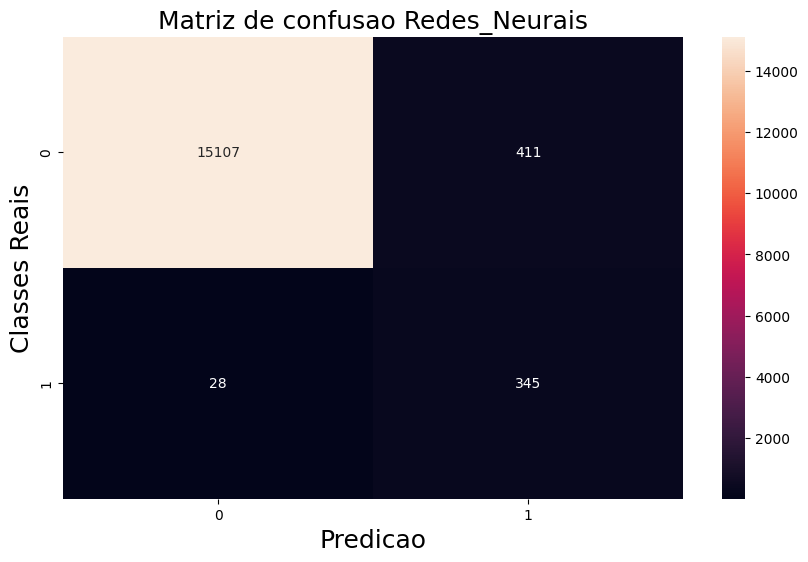

-----------------------------------------------------------------


In [26]:
matriz_confusao_matplotlib(modelos,y_teste, x_teste, diretorio='matriz_confusao_menor_custo', threshold=menor_custo, salvar=True)

In [27]:
for kay, model in modelos.items():
    if kay == 'Redes_Neurais':
        y_proba = model.predict(x_teste)
        y_pred_redes = (y_proba > menor_custo).astype(int).squeeze()
        matriz_confusao_plot(y_teste, y_pred_redes, f'Matriz de Confusão {kay}')
    else:
        y_proba = model.predict_proba(x_teste)[:,1]
        y_pred = (y_proba > menor_custo)
        matriz_confusao_plot(y_teste, y_pred, f'Matriz de Confusão {kay}')

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## Calibrando os modelos

In [28]:
# Compute ECE using calibration_curve
def compute_ece(y_true, y_prob, n_bins=10, strategy='uniform'):
    true_frequencies, predicted_probabilities = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy=strategy)
    bin_edges = np.linspace(0, 1, n_bins+1)
    bin_width = 1.0 / n_bins
    bin_centers = np.linspace(bin_width/2, 1.0 - bin_width/2, n_bins)
    weights, _ = np.histogram(y_prob, bins=bin_edges, range=(0, 1))
    ece = np.sum(weights * np.abs(predicted_probabilities - bin_centers)) / len(y_prob)
    return ece

In [29]:
def calibrations_metrics(modelos, x_teste, y_teste):
    predictions = {}
    for name, model in modelos.items():
        if name == 'Redes_Neurais':
            predictions[name] = model.predict(x_teste).squeeze()
        else:
            predictions[name] = model.predict_proba(x_teste)[:, 1]
    results = {
        "Model": [],
        "Log Loss": [],
        "Brier Loss": [],
        "ECE": []
    }
    for name, preds in predictions.items():
        results["Model"].append(name)
        results["Log Loss"].append(log_loss(y_teste, preds))
        results["Brier Loss"].append(brier_score_loss(y_teste, preds))
        try:
            results["ECE"].append(compute_ece(y_teste, preds))
        except ValueError:
            results["ECE"].append(np.nan)
            
            

    results_df = pd.DataFrame(results)
    return results_df, predictions

In [30]:
def calibracao_plot(predictions, diretorio, colors=None,salvar=False):
    # Calibration Plot
    if colors is None:
        colors = ['blue', 'orange', 'green', 'red','purple','black','cyan','magenta']
    plt.figure(figsize=(12, 9))
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated", color='gray')
    for color, (name, preds) in zip(colors, predictions.items()):
        frac, mean = calibration_curve(y_teste, preds, n_bins=10)
        plt.plot(mean, frac, "s-", label=name, color=color)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Plot")
    plt.legend()
    plt.grid(True)
    if salvar:
        plt.savefig(diretorio, dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
results_df, predictions = calibrations_metrics(modelos, x_teste, y_teste)

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/tmp/ipykernel_33276/3068740344.py:6: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



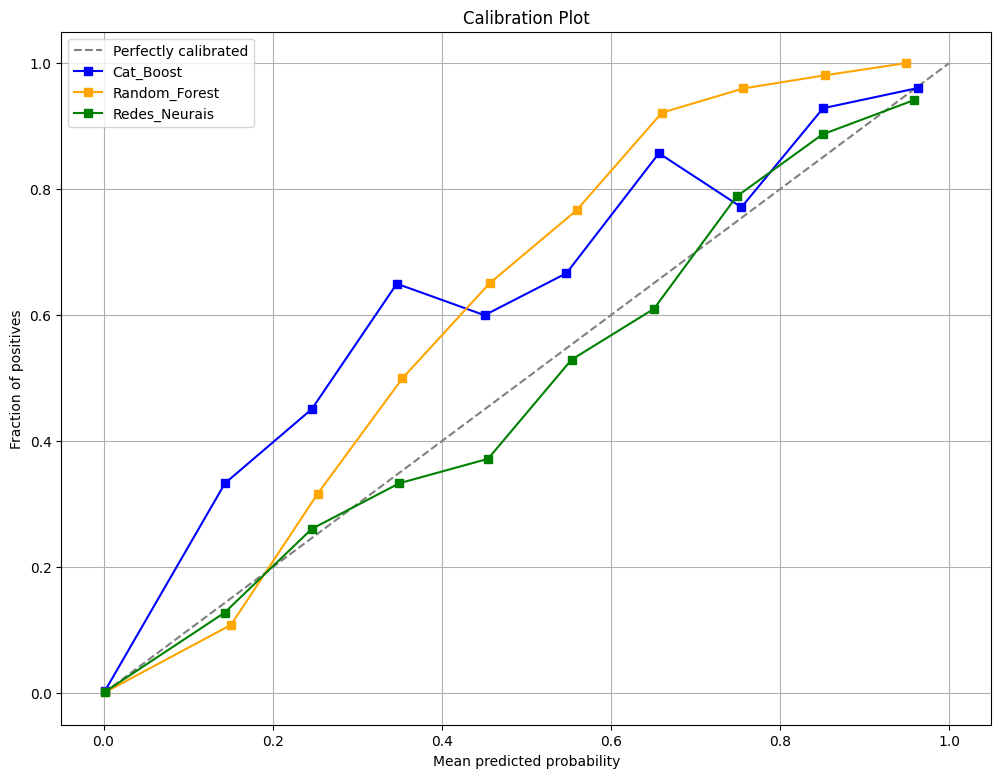

In [32]:
calibracao_plot(predictions,salvar=True,diretorio='imagens/calibracao_plot.png')

In [33]:
results_df

Model  Log Loss  Brier Loss       ECE
0      Cat_Boost  0.026823    0.007364  0.047419
1  Random_Forest  0.042871    0.007887  0.045998
2  Redes_Neurais  0.030336    0.008302  0.046441

### Calibrando com VennAbers

In [34]:
class KerasTrainedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        # Este método não será chamado, pois o modelo já está treinado
        pass
    
    def predict(self, X):
        return self.model.predict(X).squeeze()
    
    #transformar para o formato do predict_proba do sklearn
    def predict_proba(self,X):
        probs = modelos['Redes_Neurais'].predict(X)
        # Transforme as previsões para o formato o
        probs_transformed = np.hstack((1 - probs, probs))
        return probs_transformed


In [35]:
## Venn Aberration redes neurais
va_redes = VennAbersCalibrator(estimator=KerasTrainedRegressor(modelos['Redes_Neurais']), inductive=False, n_splits=2)
va_redes.fit(x_treino, y_treino)
va_cv_prob_redes = va_redes.predict_proba(x_teste)
modelos['Redes_Neurais_ven'] = va_redes

## Venn Aberration Grad Boost
va_random = VennAbersCalibrator(estimator=modelos['Random_Forest'], inductive=False, n_splits=2)
va_random.fit(x_treino, y_treino)
va_cv_prob_grad = va_random.predict_proba(x_teste)
modelos['Random_Forest_ven'] = va_random

## Venn Aberration Regressao Logistica
va_cat = VennAbersCalibrator(estimator=modelos['Cat_Boost'], inductive=False, n_splits=2)
va_cat.fit(x_treino, y_treino)
va_cv_prob_log = va_cat.predict_proba(x_teste)
modelos['Cat_Boost_ven'] = va_cat



932/932 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
932/932 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0:	learn: 0.4258285	total: 55.8ms	remaining: 16.7s
1:	learn: 0.2753143	total: 89ms	remaining: 13.3s
2:	learn: 0.1751326	total: 130ms	remaining: 12.9s
3:	learn: 0.1223783	total: 162ms	remaining: 12s
4:	learn: 0.0895657	total: 194ms	remaining: 11.4s
5:	learn: 0.0698583	total: 225ms	remaining: 11s
6:	learn: 0.0594785	total: 257ms	remaining: 10.7s
7:	learn: 0.0502096	total: 295ms	remaining: 10.8s
8:	learn: 0.0443091	total: 325ms	remaining: 10.5s
9:	learn: 0.0405602	total: 356ms	remaining: 10.3s
10:	learn: 0.0372038	total: 388ms	remaining: 10.2s
11:	learn: 0.0351107	total: 416ms	remaining: 9.98s
12:	learn: 0.0335545	total: 445ms	remaining: 9.84s
13:	learn: 0.0321802	total: 478ms	remaining: 9.77s
14:	learn: 0.0307341	total: 511ms	remaining: 9.71s
15:	learn: 0.0297873	total: 552ms	remaining: 9.8s
16:	learn: 0.0287497	total: 588ms	remaining: 9.79s
17:	learn: 0.0279831	tota

In [36]:
results_df, predictions = calibrations_metrics(modelos, x_teste, y_teste)

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/tmp/ipykernel_33276/3068740344.py:6: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



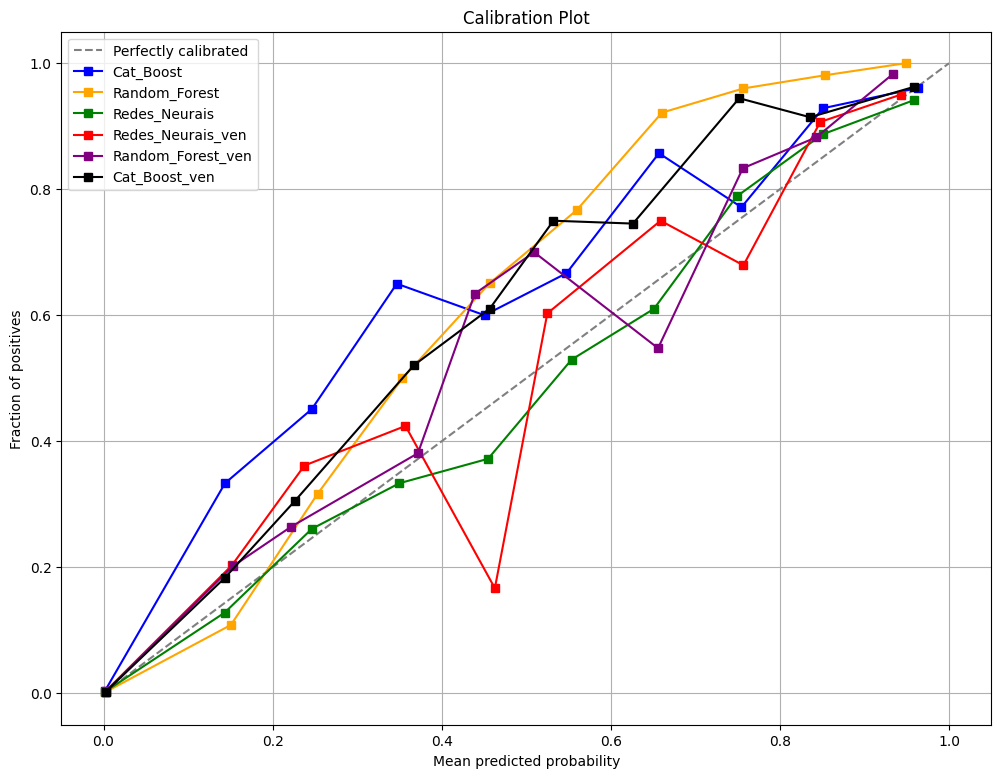

In [37]:
calibracao_plot(predictions,salvar=True,diretorio='imagens/calibracao_plot_ven.png')

In [38]:
results_df

Model  Log Loss  Brier Loss       ECE
0          Cat_Boost  0.026823    0.007364  0.047419
1      Random_Forest  0.042871    0.007887  0.045998
2      Redes_Neurais  0.030336    0.008302  0.046441
3  Redes_Neurais_ven  0.030579    0.008403  0.046214
4  Random_Forest_ven  0.029207    0.008265  0.046446
5      Cat_Boost_ven  0.028930    0.008001  0.046180

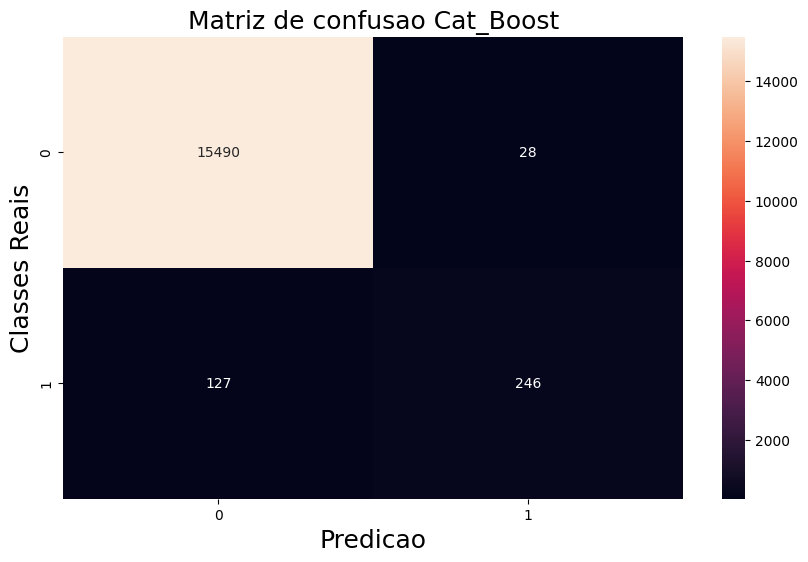

-----------------------------------------------------------------


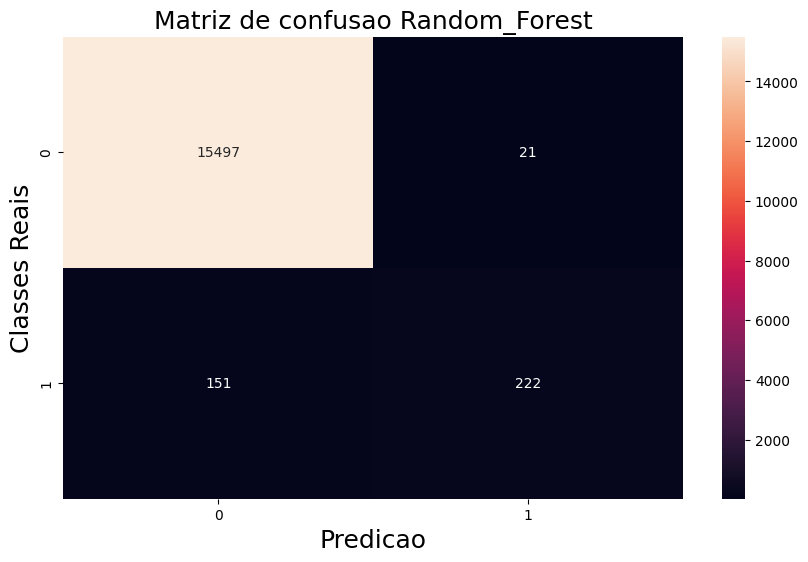

-----------------------------------------------------------------
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


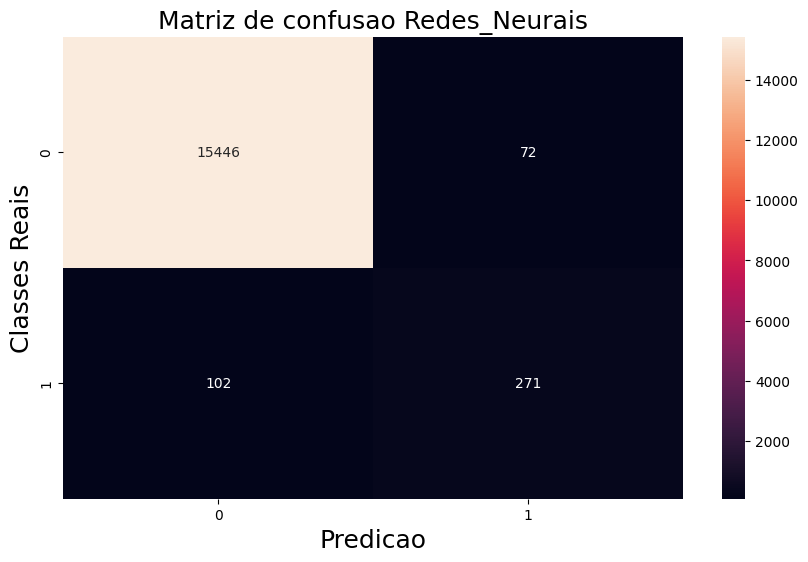

-----------------------------------------------------------------
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


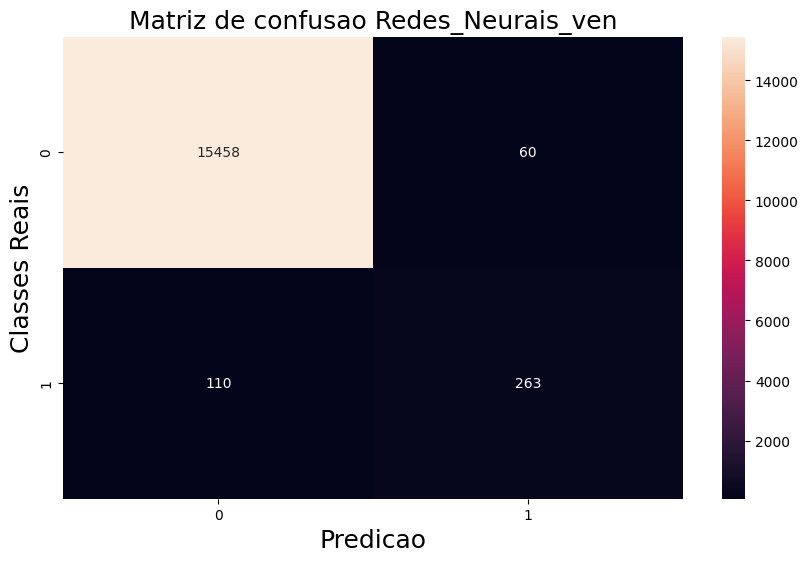

-----------------------------------------------------------------


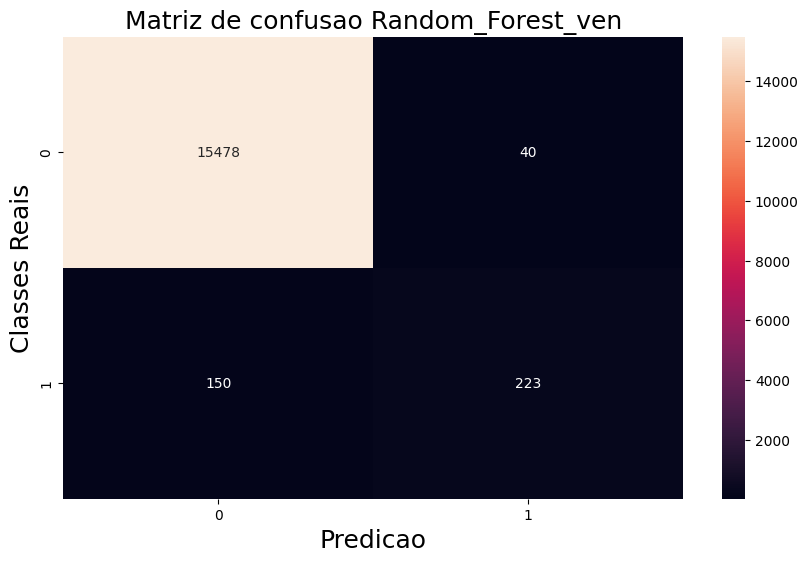

-----------------------------------------------------------------


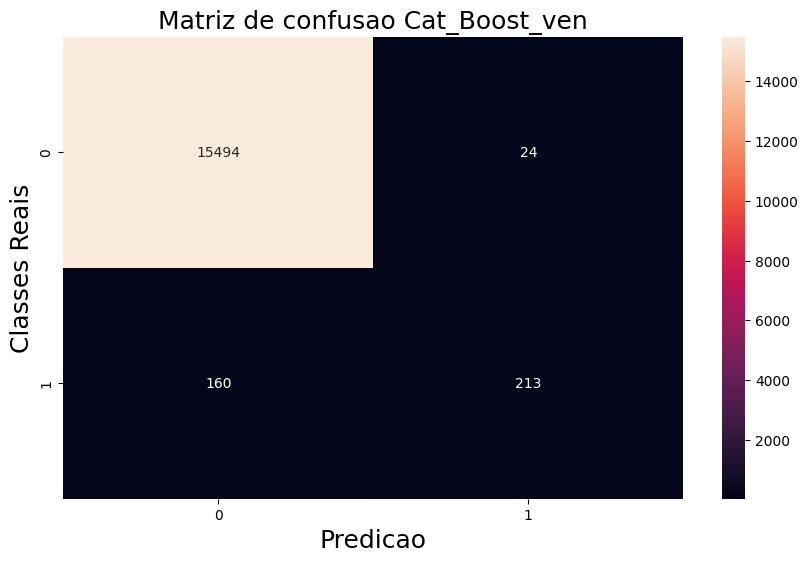

-----------------------------------------------------------------


In [39]:
matriz_confusao_matplotlib(modelos,y_teste, x_teste, diretorio='matriz_confusao_calibrada', threshold=0.5, salvar=True)

In [40]:
report_metrics(modelos, x_teste, y_teste)

Cat_Boost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15518
           1       0.90      0.66      0.76       373

    accuracy                           0.99     15891
   macro avg       0.94      0.83      0.88     15891
weighted avg       0.99      0.99      0.99     15891

-----------------------------------------------------------------
Random_Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15518
           1       0.91      0.60      0.72       373

    accuracy                           0.99     15891
   macro avg       0.95      0.80      0.86     15891
weighted avg       0.99      0.99      0.99     15891

-----------------------------------------------------------------
Redes_Neurais
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15518
           1       0.79   

In [43]:
predicao_custo_ven = custo_monetario_threshold(modelos, x_teste, y_teste)

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
497/497 ━━━━━━━━

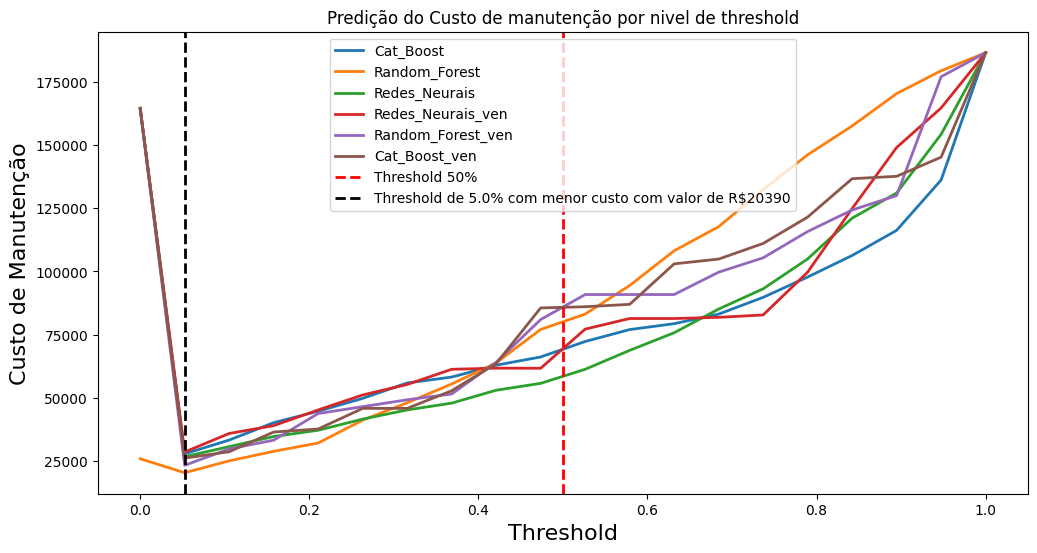

In [45]:
plot_custo_monetario_matplotlib(predicao_custo_ven, 'custo_threshold', salvar=True)

In [46]:
predicao_custo_ven

Cat_Boost  Random_Forest  Redes_Neurais  Redes_Neurais_ven  \
0.000000     164505          25915         164505             164505   
0.052632      27860          20390          26735              28585   
0.105263      33315          25070          30720              35915   
0.157895      40170          28850          34710              39020   
0.210526      44720          32140          37190              45220   
0.263158      49795          41190          41590              51145   
0.315789      55890          48055          45230              55290   
0.368421      58225          55475          47910              61295   
0.421053      62915          63845          53015              61750   
0.473684      66170          77055          55735              61700   
0.526316      72285          83130          61295              77175   
0.578947      77005          94440          68775              81380   
0.631579      79340         108175          75750              81380   
0.684211      83120         117675          85120              81845   
0.736842      89750         132380          93125              82785   
0.789474      97785         146135         104940              99725   
0.842105     106305         157535         121070             124860   
0.894737     116260         170350         131015             149015   
0.947368     136170         179375         154240             164660   
1.000000     186500         186500         186500             186500   

          Random_Forest_ven  Cat_Boost_ven  
0.000000             164505         164505  
0.052632              23310          26185  
0.105263              29805          28685  
0.157895              33265          36495  
0.210526              43805          37670  
0.263158              46515          45840  
0.315789              49235          45840  
0.368421              51530          52805  
0.421053              64075          63540  
0.473684              80975          85565  
0.526316              90860          86040  
0.578947              90860          86980  
0.631579              90860         102990  
0.684211              99715         104890  
0.736842             105375         111065  
0.789474             115785         121495  
0.842105             124295         136675  
0.894737             129995         137615  
0.947368             177010         145195  
1.000000             186500         186500